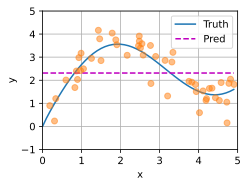

In [1]:
"""
注意力汇聚
查询（自主提示）和键（非自主提示）之间的交互形成了注意力汇聚； 
注意力汇聚有选择地聚合了值（感官输入）以生成最终的输出
"""


import torch
from torch import nn
from d2l import torch as d2l

#生成数据集
n_train = 50
x_train, _ = torch.sort(torch.rand(n_train) * 5)

def f(x):
    return 2  * torch.sin(x) + x**0.8

y_train = f(x_train) +torch.normal(0, 0.5, size=(n_train,))
x_test = torch.arange(0, 5 ,0.1)
y_truth = f(x_test)
n_test = len(x_test)

def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5)
    
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

**上文：平均汇聚**

$$
f(x) = \frac{1}{n}\sum_{i=1}^n y_i,
$$

**非参数注意力汇聚**

$$
f(x) = \sum_{i=1}^n \frac{K(x - x_i)}{\sum_{j=1}^n K(x - x_j)} y_i
$$

$$
f(x) = \sum_{i=1}^n \alpha(x, x_i) y_i
$$

其中$x$是查询，$(x_{i}, y_{i})$是键值对。注意力汇聚是$y_{i}$的加权平均。 将查询和键
之间的关系建模为注意力权重（attention weight）$\alpha(x, x_i)$。
这个权重将被分配给每一个对应值，对于任何查询，模型在所有键值对注意力权重都是一个有效的概率分布： 它们是非负的，并且总和为1

使用高斯核函数$K(u) = \frac{1}{\sqrt{2\pi}} \exp(-\frac{u^2}{2})$,代入公式可得
$$
\begin{split}\begin{aligned} f(x) &=\sum_{i=1}^n \alpha(x, x_i) y_i\\ &= \sum_{i=1}^n \frac{\exp\left(-\frac{1}{2}(x - x_i)^2\right)}{\sum_{j=1}^n \exp\left(-\frac{1}{2}(x - x_j)^2\right)} y_i \\&= \sum_{i=1}^n \mathrm{softmax}\left(-\frac{1}{2}(x - x_i)^2\right) y_i. \end{aligned}\end{split}
$$

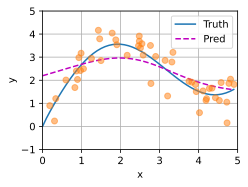

In [2]:
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

<Axes: >

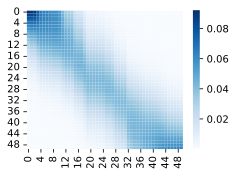

In [9]:
import seaborn as sns

sns.heatmap(attention_weights, cmap='Blues')

**带参数注意力汇聚**

$$
\begin{split}\begin{aligned}f(x) &= \sum_{i=1}^n \alpha(x, x_i) y_i \\&= \sum_{i=1}^n \frac{\exp\left(-\frac{1}{2}((x - x_i)w)^2\right)}{\sum_{j=1}^n \exp\left(-\frac{1}{2}((x - x_j)w)^2\right)} y_i \\&= \sum_{i=1}^n \mathrm{softmax}\left(-\frac{1}{2}((x - x_i)w)^2\right) y_i.\end{aligned}\end{split}
$$

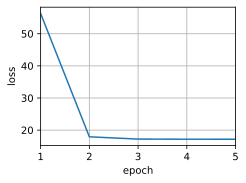

In [17]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))
        
    def forward(self, queries, keys, values):
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, 
                                                            keys.shape[1]))
        self.attention_weights = nn.functional.softmax(-
                                ((queries - keys) * self.w)**2 / 2, dim=1)
        return torch.bmm(self.attention_weights.unsqueeze(1), 
                         values.unsqueeze(-1)).reshape(-1)
        
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# keys的形状:('n_train'，'n_train'-1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

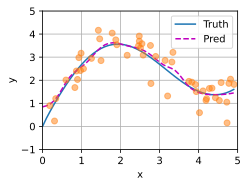

In [18]:
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))
# value的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

<Axes: >

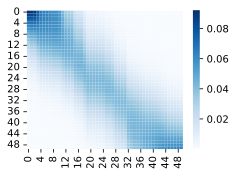

In [24]:
sns.heatmap(attention_weights.detach(), cmap='Blues')